In [12]:
from importlib import reload
from pathlib import Path

import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
sns.set_theme()
import pmdarima
import darts
from statsmodels.graphics.tsaplots import plot_acf

# Silencing Pandas warnings
import warnings
warnings.filterwarnings("ignore", message="Could not infer format")
warnings.simplefilter(action="ignore", category=pd.errors.PerformanceWarning)

pd.set_option('max_colwidth', 400)
pd.set_option("display.max_rows", 80)

In [2]:
from scripts.data_extraction import get_all_lobbying_data, lobbying_totals

lobbying_train = get_all_lobbying_data()

all_totals = lobbying_train.groupby("period_start")[["income", "expenses"]].sum()
all_totals["total"] = all_totals.sum(axis=1)

codes = [x.stem[-3:] for x in Path("lobbying_data/by_issue_code/").glob("*.csv")]
for code in codes:
    code_totals = lobbying_totals(code, adjust_for_num_codes=True)
    code_totals.columns = [code + "_" + x for x in code_totals.columns]
    all_totals = pd.merge(all_totals, code_totals, left_index=True, right_index=True)


In [7]:
import matplotlib.lines as mlines
from pmdarima import auto_arima

from sklearn.model_selection import TimeSeriesSplit

from darts import TimeSeries
from darts.metrics import msse
from darts.models import VARIMA

def cross_validate(model, col, plot=True, test_size=4, n_cv=5):
    kf = TimeSeriesSplit(n_cv, test_size=test_size)
    score = 0
    
    if plot:
        fig, ax = plt.subplots()
        sns.lineplot(col, ax=ax)
        forecast_line = mlines.Line2D([], [], color="gray", linestyle="dashed")
        true_line = mlines.Line2D([], [], color="gray", linestyle="solid")

    for train_idx, valid_idx in kf.split(col):
        col_train = TimeSeries.from_series(col.iloc[train_idx])
        col_valid = TimeSeries.from_series(col.iloc[valid_idx])

        model.fit(col_train)
        y_pred = model.predict(4)
        score += msse(col_valid, y_pred, col_train)

        if plot:
            y_pred.plot(linestyle="dashed", ax=ax)
            
    score = score / kf.get_n_splits()
    
    if plot:
        ax.legend(labels = ["observed", "forecast"], handles=[true_line, forecast_line])
        ax.set_title(col.name + f": score {score:0.3e}")
        
    return score


def cross_validate_auto_arima(col, plot=True, test_size=4, n_cv=5, metric=msse, **auto_arima_kwargs):
    kf = TimeSeriesSplit(n_cv, test_size=test_size)
    score = 0
    
    if plot:
        fig, ax = plt.subplots()
        sns.lineplot(col, ax=ax)
        forecast_line = mlines.Line2D([], [], color="gray", linestyle="dashed")
        true_line = mlines.Line2D([], [], color="gray", linestyle="solid")

    for train_idx, valid_idx in kf.split(col):
        col_train = col.iloc[train_idx]
        col_valid = col.iloc[valid_idx]
        model = auto_arima(col_train, **auto_arima_kwargs)
        model.fit(col_train)
        y_pred = model.predict(test_size)
        
        col_train = TimeSeries.from_series(col_train)
        col_valid = TimeSeries.from_series(col_valid)
        y_pred = TimeSeries.from_series(y_pred)
        score += msse(col_valid, y_pred, col_train)

        if plot:
            y_pred.plot(linestyle="dashed", ax=ax)
            
    score = score / kf.get_n_splits()
    
    if plot:
        ax.legend(labels = ["observed", "forecast"], handles=[true_line, forecast_line])
        ax.set_title(col.name + f": score {score:0.3e}")
        
    return score, model


def cross_validate_varima(code, p, d, q, trend, plot=True, n_cv=5, test_size=4, **varima_kwargs):

    kf = TimeSeriesSplit(n_splits=n_cv, test_size=test_size)
    X_df = lobbying_totals(code)[["lobbying_income", "lobbying_expenses"]]

    if plot:
        fig, ax = plt.subplots(figsize=(12,8))
        sns.lineplot(X_df["lobbying_income"], linestyle="solid", label="income", color=(0.1, 0.1, 0.8), ax=ax)
        sns.lineplot(X_df["lobbying_expenses"], linestyle="solid", label="expenses", color=(0.9, 0.6, 0.2), ax=ax)
        sns.lineplot(X_df.sum(axis=1), linestyle="solid", label="total", color="black", ax=ax)

    MSSE = 0
    for train_idx, valid_idx in kf.split(X_df):
        X_train = TimeSeries.from_dataframe(X_df.iloc[train_idx])
        X_valid = TimeSeries.from_dataframe(X_df.iloc[valid_idx])

        try:
            model = VARIMA(p=p, d=d, q=q, trend=trend).fit(X_train)
        except Exception as e:
            print(f"{code}, {p}, {d}, {q}, {trend_dict[trend]}: {e}")
            return np.nan

        preds = model.predict(len(X_valid))
        MSSE += msse(X_valid.sum(axis=1), preds.sum(axis=1), X_train.sum(axis=1), m=1)
        
        if plot:
            preds_df = preds.pd_dataframe().rename(columns=lambda x: x + "_preds")
            sns.lineplot(preds_df["lobbying_income_preds"], linestyle="dashed", label=None, color=(0.3, 0.3, 0.9), ax=ax)
            sns.lineplot(preds_df["lobbying_expenses_preds"], linestyle="dashed", label=None, color=(0.9, 0.7, 0.4), ax=ax)
            sns.lineplot(preds_df.sum(axis=1), linestyle="dashed", label=None, color="darkgray", ax=ax)

    MSSE /= kf.get_n_splits()
    if plot:
        plt.title(f"{code} | VARIMA({p=}, {d=}, {q=}, {trend_dict[trend]}) | MSSE: {MSSE:.3f}")
    return MSSE


(2.0313197352713788,
 ARIMA(order=(0, 1, 0), scoring_args={}, seasonal_order=(0, 0, 0, 4),
       suppress_warnings=True, with_intercept=False))

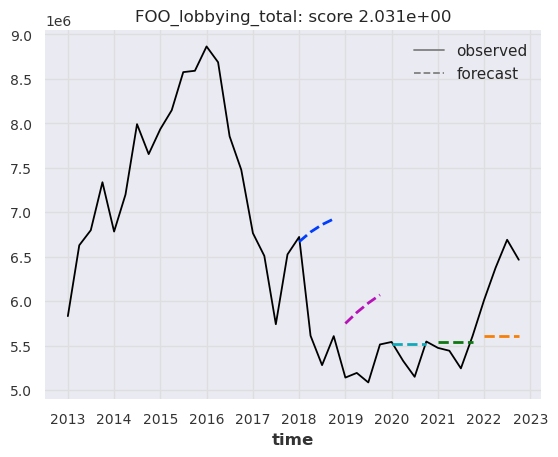

In [8]:
cross_validate_auto_arima(
    col=all_totals["FOO_lobbying_total"],
    seasonal=True,
    m=4,
)

In [9]:
from darts.models import NaiveDrift
scores = pd.DataFrame(index=codes, columns=["ARIMA_MSSE", "Drift_MSSE", "ARIMA_best_order", "ARIMA_best_seasonal_order"])

for code in codes:
    col = all_totals[f"{code}_lobbying_total"]
    score, model = cross_validate_auto_arima(col, seasonal=True, m=4, plot=False, error_action="ignore")
    scores.loc[code, "ARIMA_MSSE"] = score
    scores.loc[code, "ARIMA_best_order"] = model.order
    scores.loc[code, "ARIMA_best_seasonal_order"] = model.seasonal_order
    
    naive_score = cross_validate(NaiveDrift(), col, plot=False)
    scores.loc[code, "Drift_MSSE"] = naive_score

/home/pvk/miniconda3/envs/ML/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:1899: RuntimeWarning: divide by zero encountered in reciprocal
  return np.roots(self.polynomial_reduced_ar)**-1


In [15]:
codes_total_spending = pd.Series(index=codes)
for code in codes:
    codes_total_spending.loc[code] = all_totals[f"{code}_lobbying_total"].sum()
codes_total_spending.sort_values(ascending=False)

TAX    4.162935e+09
HCR    3.496120e+09
BUD    2.836368e+09
MMM    2.029774e+09
TRD    1.911691e+09
FIN    1.484251e+09
ENG    1.475693e+09
DEF    1.454635e+09
TRA    1.360345e+09
TEC    1.180254e+09
CPT    1.089583e+09
ENV    9.524621e+08
HOM    8.781930e+08
LBR    8.494450e+08
BAN    7.933768e+08
EDU    7.519518e+08
AGR    7.065237e+08
GOV    6.733778e+08
IMM    6.450339e+08
CSP    6.077611e+08
INS    6.055703e+08
FOR    5.842236e+08
AVI    5.720061e+08
COM    5.144469e+08
NAT    5.009208e+08
RET    4.428479e+08
SCI    4.411663e+08
CAW    4.252308e+08
PHA    4.251059e+08
LAW    3.525148e+08
CPI    3.241103e+08
HOU    3.095402e+08
VET    3.079816e+08
SMB    2.856601e+08
IND    2.679398e+08
FOO    2.609419e+08
FUE    2.482983e+08
MAR    2.481944e+08
CHM    2.202866e+08
ECN    2.201986e+08
CIV    2.140161e+08
DIS    2.050867e+08
AUT    2.017091e+08
MAN    1.987163e+08
MED    1.946516e+08
AER    1.930064e+08
INT    1.806337e+08
TOB    1.779789e+08
POS    1.647893e+08
TOR    1.635422e+08


In [24]:
scores.loc[:, "total_spending"] = codes_total_spending
scores.sort_values(by="total_spending", ascending=False, inplace=True)
scores.style.highlight_min(subset=["ARIMA_MSSE", "Drift_MSSE"], axis=1, color="darkblue")

/tmp/ipykernel_84191/980475393.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  scores.sort_values(by="total_spending", ascending=False, inplace=True)


,ARIMA_MSSE,Drift_MSSE,ARIMA_best_order,ARIMA_best_seasonal_order,total_spending
TAX,2.747246,5.648075,"(1, 0, 0)","(0, 0, 0, 4)",4162934764.953425
HCR,3.332656,1.651386,"(2, 2, 0)","(0, 0, 0, 4)",3496120170.798379
BUD,1.916260,2.294757,"(0, 0, 1)","(1, 1, 1, 4)",2836367753.950290
MMM,0.265634,1.236827,"(0, 0, 2)","(2, 1, 2, 4)",2029773923.750585
TRD,6.421244,4.022043,"(1, 0, 0)","(1, 1, 0, 4)",1911690707.915055
FIN,6.698117,2.387554,"(0, 0, 1)","(0, 0, 0, 4)",1484250883.436866
ENG,3.958671,4.928075,"(0, 1, 0)","(0, 0, 0, 4)",1475693407.033411
DEF,2.318483,2.991796,"(0, 2, 0)","(0, 0, 0, 4)",1454634739.849653
TRA,5.719805,5.270622,"(0, 1, 0)","(0, 0, 0, 4)",1360345458.157683
TEC,4.568172,3.733830,"(2, 1, 2)","(1, 0, 1, 4)",1180254093.098107


(2.295442628596029,
 ARIMA(order=(1, 1, 0), scoring_args={}, seasonal_order=(0, 0, 0, 4),
       suppress_warnings=True, with_intercept=False))

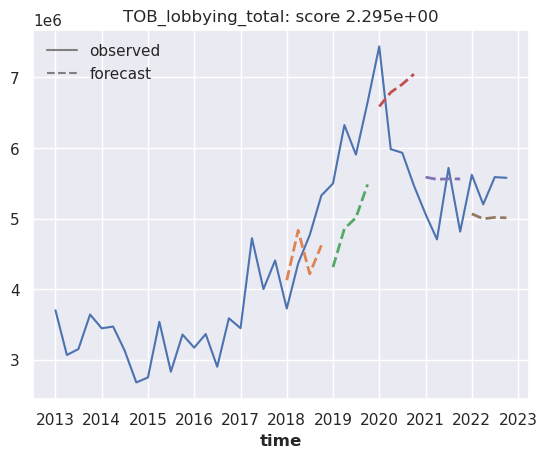

In [25]:
cross_validate_auto_arima(all_totals["TOB_lobbying_total"], seasonal=True, m=4)

These results aren't very satisfying. The ARIMA outperforms the naive drift model about half the time. We can maybe do better by modelling income and expenses separately, using VARIMA.

In [31]:
from darts.models import VARIMA
from statsmodels.tools.sm_exceptions import EstimationWarning
VARIMA.min_train_series_length = 15
warnings.filterwarnings("ignore", message="Maximum Likelihood optimization failed to converge")
warnings.filterwarnings("ignore", category=EstimationWarning)
trend_dict = {
    "ct": "linear trend",
    "n": "no trend",
}

for code in codes:
    for p in range(3):
        for q in range(3):
            if p == 0 and q == 0:
                continue
            for d, trend in [(0, "ct"), (1, "n")]:
                model_name = f"VARIMA({p=}, {d=}, {q=}, {trend_dict[trend]})"
                scores.loc[code, model_name] = cross_validate_varima(code, p, d, q, trend, plot=False)

/home/pvk/miniconda3/envs/ML/lib/python3.10/site-packages/statsmodels/tsa/statespace/varmax.py:396: UserWarning: Non-stationary starting moving-average parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting moving-average parameters'
/home/pvk/miniconda3/envs/ML/lib/python3.10/site-packages/statsmodels/tsa/statespace/varmax.py:396: UserWarning: Non-stationary starting moving-average parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting moving-average parameters'
/home/pvk/miniconda3/envs/ML/lib/python3.10/site-packages/statsmodels/tsa/statespace/varmax.py:396: UserWarning: Non-stationary starting moving-average parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting moving-average parameters'
/home/pvk/miniconda3/envs/ML/lib/python3.10/site-packages/statsmodels/tsa/statespace/varmax.py:396: UserWarning: Non-stationary starting moving-average parameters found. Using zeros as starting parameters.

In [32]:
scores.drop(
    ["ARIMA_best_order", "ARIMA_best_seasonal_order", "total_spending"],
    axis=1
).style.highlight_min(axis=1, color="darkblue")

,ARIMA_MSSE,Drift_MSSE,"VARIMA(p=0, d=0, q=1, linear trend)","VARIMA(p=0, d=1, q=1, no trend)","VARIMA(p=0, d=0, q=2, linear trend)","VARIMA(p=0, d=1, q=2, no trend)","VARIMA(p=1, d=0, q=0, linear trend)","VARIMA(p=1, d=1, q=0, no trend)","VARIMA(p=1, d=0, q=1, linear trend)","VARIMA(p=1, d=1, q=1, no trend)","VARIMA(p=1, d=0, q=2, linear trend)","VARIMA(p=1, d=1, q=2, no trend)","VARIMA(p=2, d=0, q=0, linear trend)","VARIMA(p=2, d=1, q=0, no trend)","VARIMA(p=2, d=0, q=1, linear trend)","VARIMA(p=2, d=1, q=1, no trend)","VARIMA(p=2, d=0, q=2, linear trend)","VARIMA(p=2, d=1, q=2, no trend)"
TAX,2.747246,5.648075,1.707458,1.903975,2.099591,2.408747,2.122714,4.080395,3.624725,5.596908,4.109741,6.242367,5.707529,5.129335,4.631369,5.990060,4.534866,4.742278
HCR,3.332656,1.651386,0.865752,0.878568,0.986536,0.836611,0.730105,1.195595,0.751236,0.617172,0.758455,0.610422,0.782283,1.285425,0.823545,1.639076,0.917958,1.222670
BUD,1.916260,2.294757,1.581908,1.242851,1.550662,1.034030,1.226670,1.237855,1.055736,1.531858,1.550536,1.519556,1.037801,1.105040,1.411704,1.317608,1.004112,1.159669
MMM,0.265634,1.236827,1.110918,1.182639,1.036637,0.916110,1.005550,0.962273,1.152299,0.890981,1.216620,1.010872,0.942471,1.339827,0.990571,0.824019,0.787438,0.894148
TRD,6.421244,4.022043,1.805061,1.126590,1.780085,1.222503,1.586770,1.166516,1.858636,1.653843,1.727417,1.646345,2.155352,1.321289,2.640779,1.326118,2.363940,1.223643
FIN,6.698117,2.387554,1.759037,1.014847,1.839556,1.235334,1.424220,0.915313,1.287279,0.973907,1.553534,1.290707,1.791492,1.076826,1.922875,1.440372,1.688361,1.684024
ENG,3.958671,4.928075,3.224212,1.331510,3.466295,1.513820,1.312119,1.259163,1.103681,1.718340,1.115575,1.341989,1.376765,1.180472,1.160149,1.148961,1.126920,1.231880
DEF,2.318483,2.991796,2.364160,1.840702,2.287042,1.259089,1.626287,1.472810,1.601015,2.074061,1.480321,1.916210,1.532322,1.591357,1.444791,1.803064,1.363926,1.497918
TRA,5.719805,5.270622,0.879309,1.132419,1.031379,1.011869,0.763377,1.464626,0.831796,1.149078,0.904548,1.570380,1.003841,1.393331,0.976630,1.405695,1.046538,1.199197
TEC,4.568172,3.733830,0.800624,1.492304,0.772720,2.226572,0.823399,1.912251,0.894255,2.275784,0.821586,3.626174,0.832529,1.961741,1.072752,2.779525,0.967347,3.151094


On some, noisy categories like ART and UNM, the predictions are bad across the board.

317.08453500601615

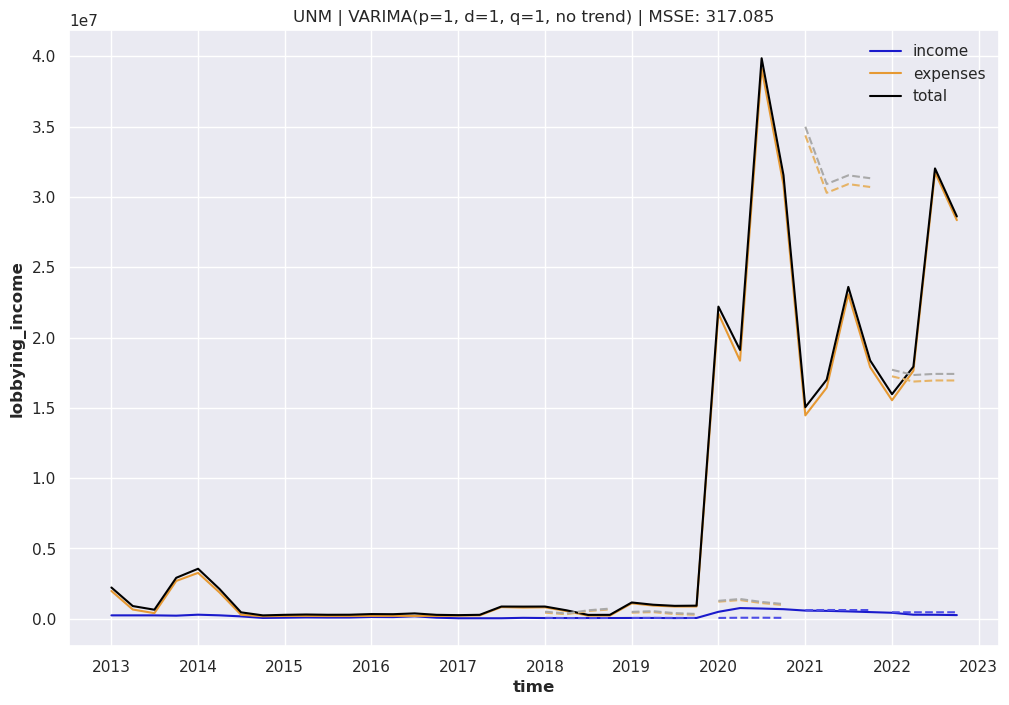

In [49]:
cross_validate_varima("UNM", 1, 1, 1, "n")

Let's focus on the 40 categories with the most spending. For these, VARIMA(0, 1, 1, no trend) -- an integrated MA(1) model -- is the best choice. Note that the forecasts made by this model agree with the naive seasonal forecast that just constantly predicts the last seen value!

In [48]:
scores.drop(
    ["ARIMA_best_order", "ARIMA_best_seasonal_order", "total_spending"],
    axis=1
).iloc[:40].mean().sort_values(ascending=True)

VARIMA(p=0, d=1, q=1, no trend)        2.126708
VARIMA(p=1, d=1, q=0, no trend)        2.178519
VARIMA(p=2, d=1, q=0, no trend)        2.212997
VARIMA(p=1, d=0, q=0, linear trend)    2.249218
VARIMA(p=0, d=1, q=2, no trend)        2.273867
VARIMA(p=1, d=0, q=1, linear trend)    2.315035
VARIMA(p=2, d=1, q=1, no trend)        2.328157
VARIMA(p=1, d=1, q=2, no trend)        2.329664
VARIMA(p=1, d=1, q=1, no trend)        2.329689
VARIMA(p=0, d=0, q=1, linear trend)    2.348162
VARIMA(p=2, d=1, q=2, no trend)        2.365507
VARIMA(p=1, d=0, q=2, linear trend)    2.387597
VARIMA(p=0, d=0, q=2, linear trend)    2.418187
VARIMA(p=2, d=0, q=0, linear trend)    2.431285
VARIMA(p=2, d=0, q=2, linear trend)    2.468764
VARIMA(p=2, d=0, q=1, linear trend)     2.52035
Drift_MSSE                             4.518178
ARIMA_MSSE                             4.881217
dtype: object

5.4943008853807

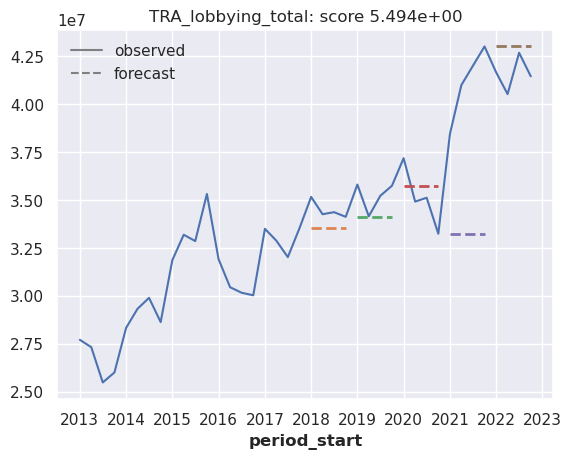

In [56]:
from darts.models import NaiveSeasonal
cross_validate(NaiveSeasonal(), all_totals["TRA_lobbying_total"])

Let's try one more thing: modelling and removing seasonality from expenses and fitting ARIMA to the residuals.

<Axes: xlabel='period_start'>

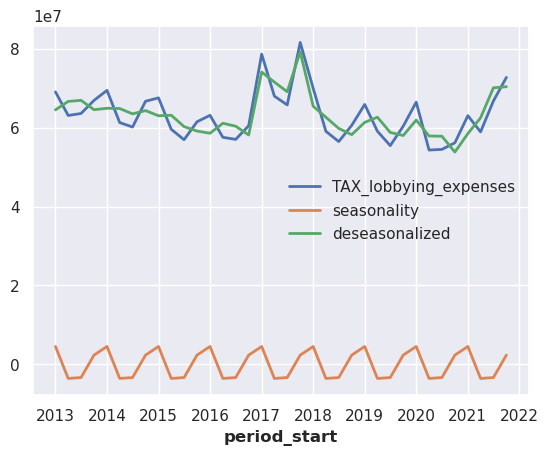

In [80]:
from darts.utils.statistics import extract_trend_and_seasonality
from darts.utils.utils import SeasonalityMode
X = TimeSeries.from_series(all_totals["TAX_lobbying_expenses"])
X_train, X_valid = X[:-4], X[-4:]
_, seas = extract_trend_and_seasonality(X_train, model=SeasonalityMode.ADDITIVE, freq=4)
X_train_deseas = X_train - seas
X_valid_deseas = X_valid - seas[-4:]
X_train.plot()
seas.plot(label="seasonality")
X_train_deseas.plot(label="deseasonalized")


0.08121795612345187


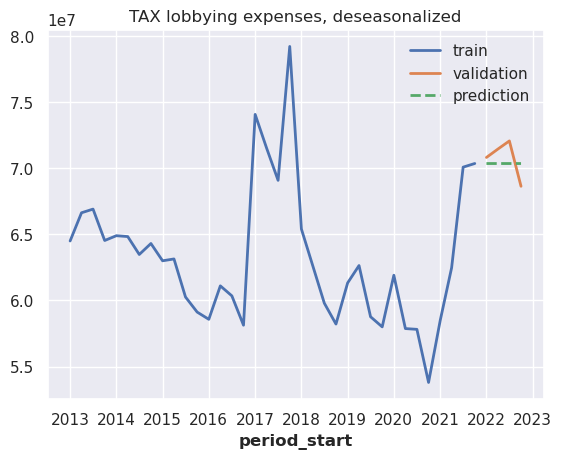

In [91]:
from darts.models import ARIMA
model = ARIMA(p=1, d=1, q=0, trend="n")
model.fit(X_train_deseas)
X_pred_deseas = model.predict(4)
X_train_deseas.plot(label="train")
X_valid_deseas.plot(label="validation")
X_pred_deseas.plot(linestyle="dashed", label="prediction")
plt.title("TAX lobbying expenses, deseasonalized")
print(msse(X_valid_deseas, X_pred_deseas, X_train_deseas))

0.03674468517585072


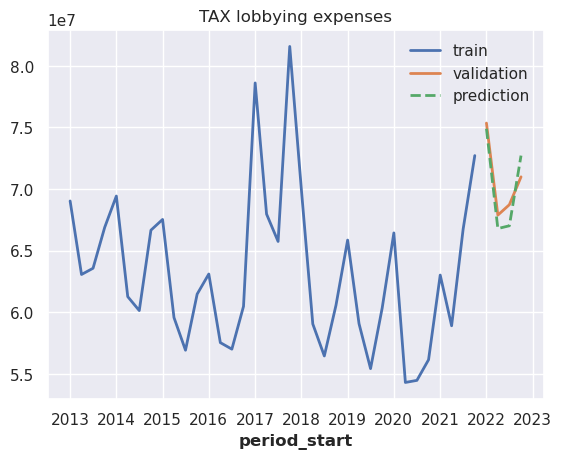

In [92]:
X_pred = X_pred_deseas + seas[-4:]
X_train.plot(label="train")
X_valid.plot(label="validation")
X_pred.plot(linestyle="dashed", label="prediction")
plt.title("TAX lobbying expenses")
print(msse(X_valid, X_pred, X_train))

In [109]:
from darts.timeseries import concatenate
def cross_validate_seasonal_varima(code, p, d, q, trend, plot=True, n_cv=5, test_size=4):

    kf = TimeSeriesSplit(n_splits=n_cv, test_size=test_size)
    X_df = lobbying_totals(code)[["lobbying_income", "lobbying_expenses"]]

    if plot:
        fig, ax = plt.subplots(figsize=(12,8))
        sns.lineplot(X_df["lobbying_income"], linestyle="solid", label="income", color=(0.1, 0.1, 0.8), ax=ax)
        sns.lineplot(X_df["lobbying_expenses"], linestyle="solid", label="expenses", color=(0.9, 0.6, 0.2), ax=ax)
        sns.lineplot(X_df.sum(axis=1), linestyle="solid", label="total", color="black", ax=ax)

    MSSE = 0
    for train_idx, valid_idx in kf.split(X_df):
        income_train = TimeSeries.from_series(X_df["lobbying_income"].iloc[train_idx])
        income_valid = TimeSeries.from_series(X_df["lobbying_income"].iloc[valid_idx])
        expenses_train = TimeSeries.from_series(X_df["lobbying_expenses"].iloc[train_idx])
        expenses_valid = TimeSeries.from_series(X_df["lobbying_expenses"].iloc[valid_idx])
        X_train = concatenate([income_train, expenses_train], axis=1)
        X_valid = concatenate([income_valid, expenses_valid], axis=1)
        
        _, seas = extract_trend_and_seasonality(expenses_train, model=SeasonalityMode.ADDITIVE, freq=4)
        expenses_train_deseas = expenses_train - seas
        X_train_deseas = concatenate([income_train, expenses_train_deseas], axis=1)

        try:
            model = VARIMA(p=p, d=d, q=q, trend=trend).fit(X_train_deseas)
        except Exception as e:
            print(f"{code}, {p}, {d}, {q}, {trend_dict[trend]}: {e}")
            return np.nan

        preds_deseas = model.predict(test_size)
        preds = preds_deseas + concatenate([TimeSeries.from_series(np.zeros(test_size)), seas[-test_size:]], axis=1, ignore_time_axis=True)
        MSSE += msse(X_valid.sum(axis=1), preds.sum(axis=1), X_train.sum(axis=1), m=1)
        
        if plot:
            preds_df = preds.pd_dataframe().rename(columns=lambda x: x + "_preds")
            sns.lineplot(preds_df["lobbying_income_preds"], linestyle="dashed", label=None, color=(0.3, 0.3, 0.9), ax=ax)
            sns.lineplot(preds_df["lobbying_expenses_preds"], linestyle="dashed", label=None, color=(0.9, 0.7, 0.4), ax=ax)
            sns.lineplot(preds_df.sum(axis=1), linestyle="dashed", label=None, color="darkgray", ax=ax)

    MSSE /= kf.get_n_splits()
    if plot:
        plt.title(f"{code} | VARIMA({p=}, {d=}, {q=}, {trend_dict[trend]}) | MSSE: {MSSE:.3f}")
    return MSSE

6.434102619503345

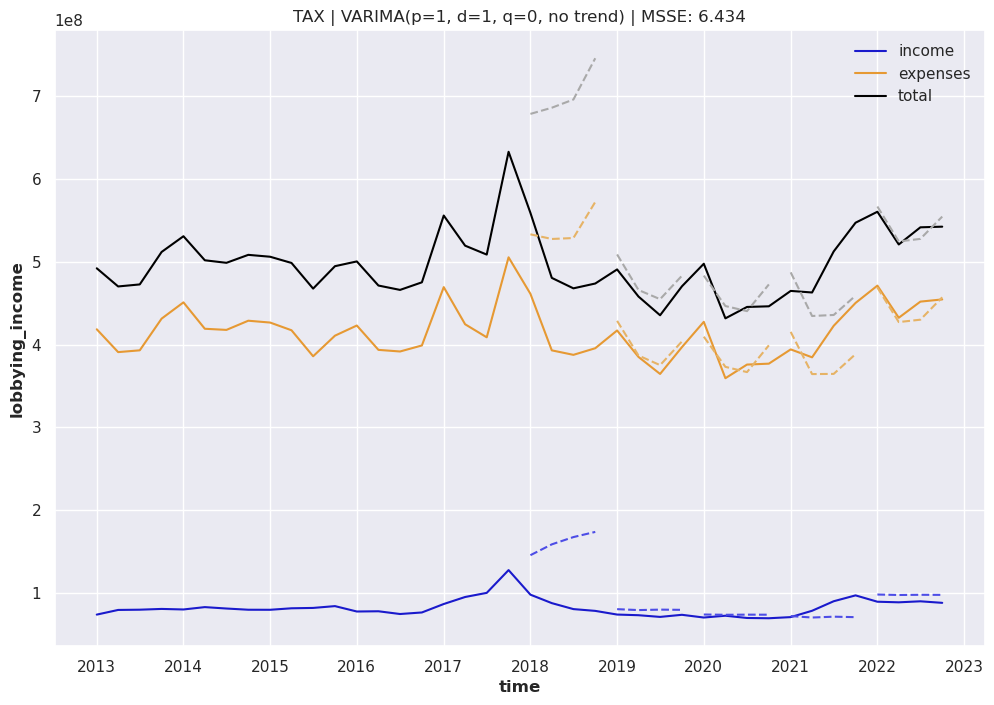

In [111]:
cross_validate_seasonal_varima("TAX", 1, 1, 0, "n")

In [114]:
for code in codes:
    for p in range(3):
        for q in range(3):
            if p == 0 and q == 0:
                continue
            for d, trend in [(0, "ct"), (1, "n")]:
                model_name = f"Seasonal VARIMA({p=}, {d=}, {q=}, {trend_dict[trend]})"
                scores.loc[code, model_name] = cross_validate_seasonal_varima(code, p, d, q, trend, plot=False)

/tmp/ipykernel_84191/16275015.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  scores.loc[code, model_name] = cross_validate_seasonal_varima(code, p, d, q, trend, plot=False)
/tmp/ipykernel_84191/16275015.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  scores.loc[code, model_name] = cross_validate_seasonal_varima(code, p, d, q, trend, plot=False)
/tmp/ipykernel_84191/16275015.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,c

In [115]:
scores.drop(
    ["ARIMA_best_order", "ARIMA_best_seasonal_order", "total_spending"],
    axis=1
).style.highlight_min(axis=1, color="darkblue")

,ARIMA_MSSE,Drift_MSSE,"VARIMA(p=0, d=0, q=1, linear trend)","VARIMA(p=0, d=1, q=1, no trend)","VARIMA(p=0, d=0, q=2, linear trend)","VARIMA(p=0, d=1, q=2, no trend)","VARIMA(p=1, d=0, q=0, linear trend)","VARIMA(p=1, d=1, q=0, no trend)","VARIMA(p=1, d=0, q=1, linear trend)","VARIMA(p=1, d=1, q=1, no trend)","VARIMA(p=1, d=0, q=2, linear trend)","VARIMA(p=1, d=1, q=2, no trend)","VARIMA(p=2, d=0, q=0, linear trend)","VARIMA(p=2, d=1, q=0, no trend)","VARIMA(p=2, d=0, q=1, linear trend)","VARIMA(p=2, d=1, q=1, no trend)","VARIMA(p=2, d=0, q=2, linear trend)","VARIMA(p=2, d=1, q=2, no trend)","Seasonal VARIMA(p=0, d=0, q=1, linear trend)","Seasonal VARIMA(p=0, d=1, q=1, no trend)","Seasonal VARIMA(p=0, d=0, q=2, linear trend)","Seasonal VARIMA(p=0, d=1, q=2, no trend)","Seasonal VARIMA(p=1, d=0, q=0, linear trend)","Seasonal VARIMA(p=1, d=1, q=0, no trend)","Seasonal VARIMA(p=1, d=0, q=1, linear trend)","Seasonal VARIMA(p=1, d=1, q=1, no trend)","Seasonal VARIMA(p=1, d=0, q=2, linear trend)","Seasonal VARIMA(p=1, d=1, q=2, no trend)","Seasonal VARIMA(p=2, d=0, q=0, linear trend)","Seasonal VARIMA(p=2, d=1, q=0, no trend)","Seasonal VARIMA(p=2, d=0, q=1, linear trend)","Seasonal VARIMA(p=2, d=1, q=1, no trend)","Seasonal VARIMA(p=2, d=0, q=2, linear trend)","Seasonal VARIMA(p=2, d=1, q=2, no trend)"
TAX,2.747246,5.648075,1.707458,1.903975,2.099591,2.408747,2.122714,4.080395,3.624725,5.596908,4.109741,6.242367,5.707529,5.129335,4.631369,5.990060,4.534866,4.742278,1.732948,3.187025,1.798091,5.223894,2.748552,6.434103,3.788304,6.262278,2.399997,8.224429,4.424998,5.382444,3.468118,4.803320,5.109816,3.922737
HCR,3.332656,1.651386,0.865752,0.878568,0.986536,0.836611,0.730105,1.195595,0.751236,0.617172,0.758455,0.610422,0.782283,1.285425,0.823545,1.639076,0.917958,1.222670,0.688512,0.828532,0.645827,0.685779,0.591828,0.831451,0.687103,1.232759,0.656319,0.831184,0.722418,0.807825,0.749356,0.884561,0.850890,1.062391
BUD,1.916260,2.294757,1.581908,1.242851,1.550662,1.034030,1.226670,1.237855,1.055736,1.531858,1.550536,1.519556,1.037801,1.105040,1.411704,1.317608,1.004112,1.159669,1.319087,0.854055,1.369551,0.997901,0.896848,0.878336,0.978911,1.340240,1.256297,1.552622,1.023261,0.809591,1.173346,1.473034,1.399086,1.942848
MMM,0.265634,1.236827,1.110918,1.182639,1.036637,0.916110,1.005550,0.962273,1.152299,0.890981,1.216620,1.010872,0.942471,1.339827,0.990571,0.824019,0.787438,0.894148,0.621146,0.541804,0.655136,0.551176,0.394862,0.359881,0.357195,0.274737,0.459327,0.550367,0.445081,0.428840,0.468647,0.482696,0.499071,0.423422
TRD,6.421244,4.022043,1.805061,1.126590,1.780085,1.222503,1.586770,1.166516,1.858636,1.653843,1.727417,1.646345,2.155352,1.321289,2.640779,1.326118,2.363940,1.223643,1.532112,0.979201,1.651296,0.986955,1.599516,1.053149,1.533666,1.031818,1.498109,0.975465,1.631175,1.157706,2.060309,1.075598,1.704112,1.003830
FIN,6.698117,2.387554,1.759037,1.014847,1.839556,1.235334,1.424220,0.915313,1.287279,0.973907,1.553534,1.290707,1.791492,1.076826,1.922875,1.440372,1.688361,1.684024,1.893857,1.070043,1.983409,1.727130,1.502858,1.044691,1.399170,1.405878,1.217012,1.756839,1.854639,1.330710,2.019403,1.729443,1.845319,1.582452
ENG,3.958671,4.928075,3.224212,1.331510,3.466295,1.513820,1.312119,1.259163,1.103681,1.718340,1.115575,1.341989,1.376765,1.180472,1.160149,1.148961,1.126920,1.231880,3.221440,1.331179,3.523512,1.109406,1.385846,1.260662,1.157675,1.276682,1.340252,1.074765,1.153808,1.170466,1.021221,1.053882,1.009264,1.251212
DEF,2.318483,2.991796,2.364160,1.840702,2.287042,1.259089,1.626287,1.472810,1.601015,2.074061,1.480321,1.916210,1.532322,1.591357,1.444791,1.803064,1.363926,1.497918,2.430970,1.800567,2.497832,2.114455,1.554057,1.541091,1.624440,1.741626,1.726002,2.084172,1.640675,2.053528,1.490600,2.325332,1.523220,1.899500
TRA,5.719805,5.270622,0.879309,1.132419,1.031379,1.011869,0.763377,1.464626,0.831796,1.149078,0.904548,1.570380,1.003841,1.393331,0.976630,1.405695,1.046538,1.199197,1.011960,1.222432,1.007452,1.113127

In [160]:
# What's the average score per model (arbitrarily restricting to the 50 most lobbied codes, to exclude outliers?)
scores.drop(
    ["ARIMA_best_order", "ARIMA_best_seasonal_order", "total_spending"],
    axis=1
).iloc[:50].mean().sort_values(ascending=True)

VARIMA(p=0, d=1, q=1, no trend)                 2.206879
Seasonal VARIMA(p=0, d=1, q=1, no trend)        2.209239
Seasonal VARIMA(p=2, d=1, q=0, no trend)        2.307733
Seasonal VARIMA(p=1, d=1, q=0, no trend)        2.324264
Seasonal VARIMA(p=0, d=1, q=2, no trend)        2.324681
VARIMA(p=1, d=0, q=0, linear trend)             2.331979
VARIMA(p=0, d=1, q=2, no trend)                  2.33364
Seasonal VARIMA(p=1, d=1, q=1, no trend)        2.343207
Seasonal VARIMA(p=1, d=0, q=1, linear trend)    2.362684
VARIMA(p=1, d=1, q=0, no trend)                 2.365948
Seasonal VARIMA(p=1, d=0, q=0, linear trend)    2.378105
Seasonal VARIMA(p=2, d=1, q=2, no trend)        2.380356
Seasonal VARIMA(p=2, d=1, q=1, no trend)        2.387757
Seasonal VARIMA(p=1, d=0, q=2, linear trend)    2.395975
VARIMA(p=1, d=0, q=1, linear trend)             2.395985
Seasonal VARIMA(p=1, d=1, q=2, no trend)        2.419212
VARIMA(p=2, d=1, q=0, no trend)                 2.422327
VARIMA(p=1, d=1, q=2, no trend)

In [158]:
# How many times does each model perform best?
scores_simple = scores.drop(
    ["ARIMA_best_order", "ARIMA_best_seasonal_order", "total_spending"],
    axis=1
)
scores_simple.iloc[:50].eq(scores_simple.iloc[:50].min(axis=1), axis=0).dot(scores_simple.columns + ",").str.rstrip(",").value_counts()

ARIMA_MSSE                                      5
Drift_MSSE                                      4
VARIMA(p=1, d=1, q=2, no trend)                 4
VARIMA(p=1, d=1, q=0, no trend)                 4
Seasonal VARIMA(p=2, d=0, q=2, linear trend)    3
VARIMA(p=0, d=1, q=2, no trend)                 3
VARIMA(p=0, d=0, q=1, linear trend)             3
Seasonal VARIMA(p=1, d=1, q=2, no trend)        3
VARIMA(p=0, d=0, q=2, linear trend)             2
Seasonal VARIMA(p=2, d=1, q=2, no trend)        2
Seasonal VARIMA(p=1, d=0, q=0, linear trend)    2
VARIMA(p=2, d=1, q=2, no trend)                 2
Seasonal VARIMA(p=1, d=1, q=1, no trend)        2
VARIMA(p=2, d=1, q=0, no trend)                 2
Seasonal VARIMA(p=1, d=0, q=1, linear trend)    1
Seasonal VARIMA(p=0, d=1, q=2, no trend)        1
VARIMA(p=1, d=0, q=1, linear trend)             1
VARIMA(p=1, d=1, q=1, no trend)                 1
VARIMA(p=0, d=1, q=1, no trend)                 1
VARIMA(p=2, d=0, q=2, linear trend)             1


The choice of model is not entirely clear. Seasonal VARIMA still feels compelling because it's taking advantage of known structure in the data. Of the Seasonal VARIMA models, Seasonal VARIMA(0,1,1) has the best average performance across the most-lobbied codes. Note that forecasts of this model correspond to assuming that income is constant, and that expenses are completely periodic. Let's visualize some of these predictions:

1.2224321611018159

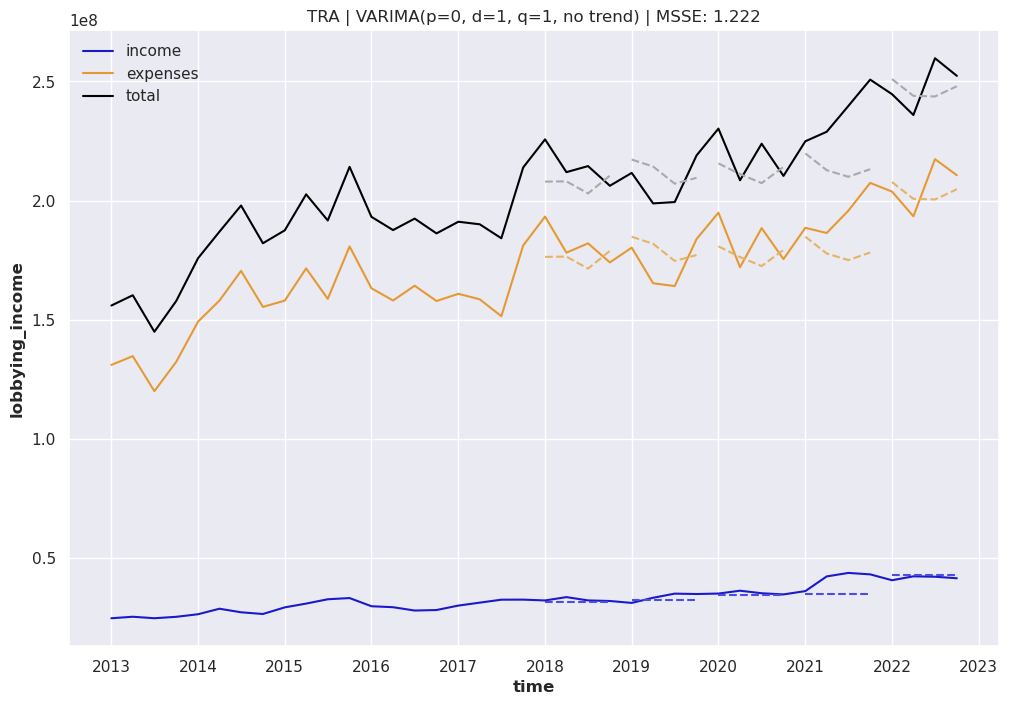

In [171]:
cross_validate_seasonal_varima("TRA", 0, 1, 1, "n")

0.6725116425339037

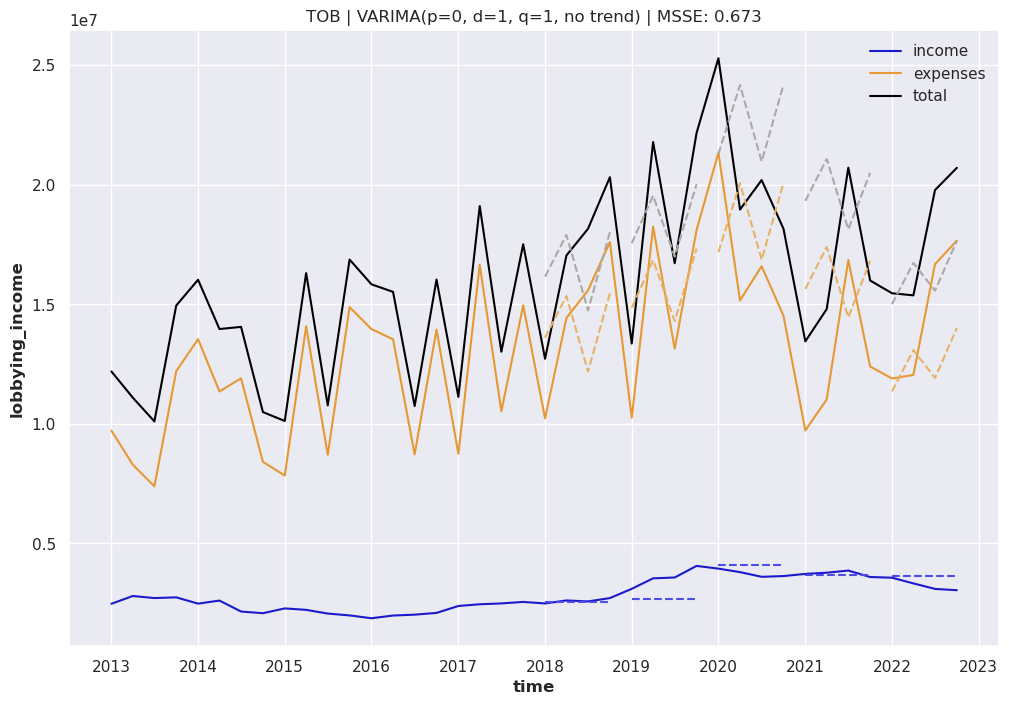

In [172]:
cross_validate_seasonal_varima("TOB", 0, 1, 1, "n")

Here are the predictions we get by running this model for all lobbying codes and summing the results:

In [178]:
all_preds.values()

array([[1.83814663e+08, 1.57900501e+09],
       [1.83814663e+08, 1.43124466e+09],
       [1.83814663e+08, 1.30078023e+09],
       [1.83814663e+08, 1.31728489e+09]])

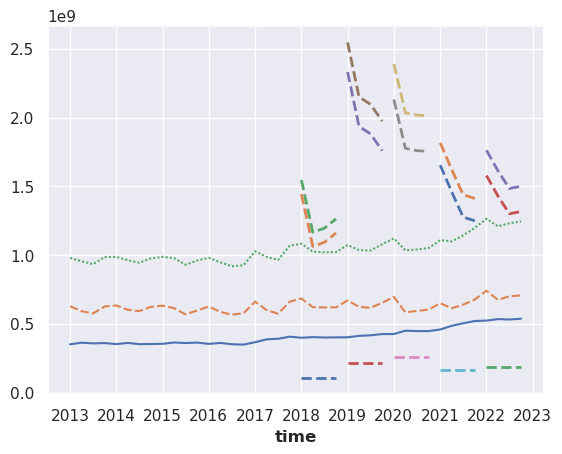

In [183]:
n_cv = 5
test_size = 4
kf = TimeSeriesSplit(n_splits=n_cv, test_size=test_size)
X_df = lobbying_totals(code)[["lobbying_income", "lobbying_expenses"]]


for train_idx, valid_idx in kf.split(X_df):
    all_preds = None
    for code in codes:
        income_train = TimeSeries.from_series(X_df["lobbying_income"].iloc[train_idx])
        income_valid = TimeSeries.from_series(X_df["lobbying_income"].iloc[valid_idx])
        expenses_train = TimeSeries.from_series(X_df["lobbying_expenses"].iloc[train_idx])
        expenses_valid = TimeSeries.from_series(X_df["lobbying_expenses"].iloc[valid_idx])
        X_train = concatenate([income_train, expenses_train], axis=1)
        X_valid = concatenate([income_valid, expenses_valid], axis=1)

        _, seas = extract_trend_and_seasonality(expenses_train, model=SeasonalityMode.ADDITIVE, freq=4)
        expenses_train_deseas = expenses_train - seas
        X_train_deseas = concatenate([income_train, expenses_train_deseas], axis=1)

        model = VARIMA(p=0, d=1, q=1, trend="n").fit(X_train_deseas)

        preds_deseas = model.predict(test_size)
        preds = preds_deseas + concatenate([TimeSeries.from_series(np.zeros(test_size)), seas[-test_size:]], axis=1, ignore_time_axis=True)
        if all_preds is None:
            all_preds = preds
        else:
            all_preds += preds
    all_preds.plot(linestyle="dashed", label=None)
    all_preds.sum(axis=1).plot(linestyle="dashed", label=None)
    
    
sns.lineplot(all_totals[["income", "expenses", "total"]], ax=plt.gca(), linestyle="solid")
plt.gca().get_legend().remove()     

The model significantly overpredicts total expenses, especially at the beginning of a year -- maybe showing an overfitting to the cyclical behavior in expenses.